Original


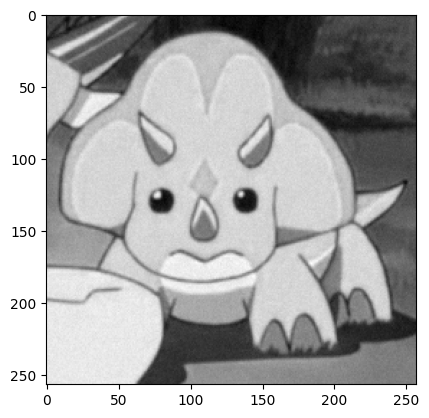

In [82]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage import color, io, util, transform

import matplotlib as mpl
mpl.rc('image', cmap='gray') #para no tener que pasar cmap='gray' cada vez que ploteo algo

input = io.imread('gabu.jpg')
image = util.img_as_float32(transform.resize(input, (257, 257), anti_aliasing=True))
#assert len(image.shape) == 2 and image.shape[0] == image.shape[1]
image = image[...,0]
N = image.shape[0]

print('Original')
plt.figure()
plt.imshow(image)


/home/mariano/ITBA/ASSD/assd_env/lib/python3.11/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Sinograma


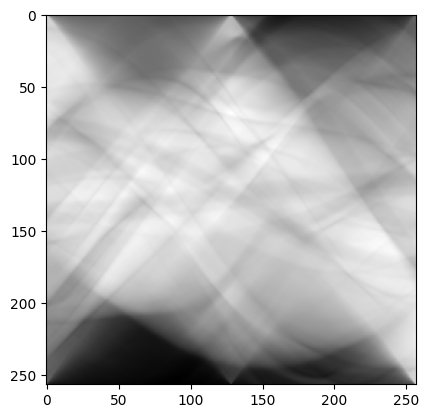

In [83]:
max_angle = 180.0 
angles = np.linspace(0.0, max_angle, N)
sinogram = transform.radon(image, theta=angles)

print('Sinograma')
plt.figure()
plt.imshow(sinogram)

In [84]:
angles

array([  0.      ,   0.703125,   1.40625 ,   2.109375,   2.8125  ,
         3.515625,   4.21875 ,   4.921875,   5.625   ,   6.328125,
         7.03125 ,   7.734375,   8.4375  ,   9.140625,   9.84375 ,
        10.546875,  11.25    ,  11.953125,  12.65625 ,  13.359375,
        14.0625  ,  14.765625,  15.46875 ,  16.171875,  16.875   ,
        17.578125,  18.28125 ,  18.984375,  19.6875  ,  20.390625,
        21.09375 ,  21.796875,  22.5     ,  23.203125,  23.90625 ,
        24.609375,  25.3125  ,  26.015625,  26.71875 ,  27.421875,
        28.125   ,  28.828125,  29.53125 ,  30.234375,  30.9375  ,
        31.640625,  32.34375 ,  33.046875,  33.75    ,  34.453125,
        35.15625 ,  35.859375,  36.5625  ,  37.265625,  37.96875 ,
        38.671875,  39.375   ,  40.078125,  40.78125 ,  41.484375,
        42.1875  ,  42.890625,  43.59375 ,  44.296875,  45.      ,
        45.703125,  46.40625 ,  47.109375,  47.8125  ,  48.515625,
        49.21875 ,  49.921875,  50.625   ,  51.328125,  52.031

reconstrucción con Python


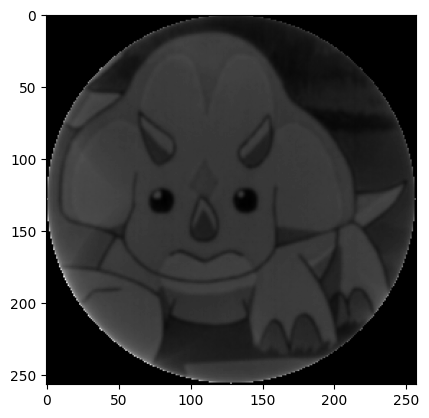

In [85]:
num_projection = N*len(angles)
r1 = transform.iradon(sinogram, theta=angles) #filter_name = alguno entre ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
print('reconstrucción con Python')
plt.figure()
plt.imshow(r1)

reconstrucción ART


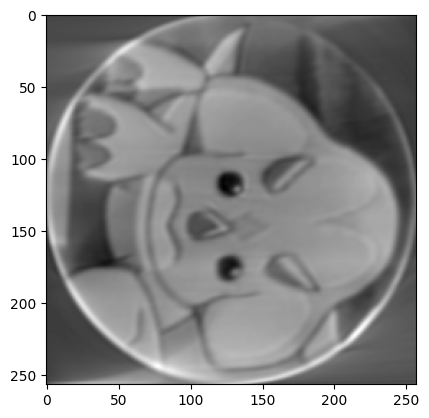

In [86]:
ir = np.zeros((N, N))
tdiff = np.zeros((N, N))
step = angles[1] - angles[0]
#L = len(ir)

niter = 1
for i in range(niter):
    for j in range(len(angles)):
        ir = transform.rotate(ir, step, order=3)
        tmp = sinogram[:,j].T * N
        temp = np.sum(ir, axis=1).T
        diff = (tmp - temp) / N
        
        for k in range(N):
            tdiff[:, k] = diff

        ir = ir + tdiff

print('reconstrucción ART')
plt.figure()
plt.imshow(ir)

reconstrucción FBP


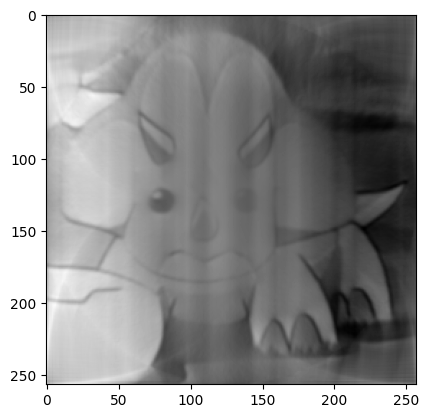

In [87]:
from scipy import fft

bp = np.zeros((N,N))
tmp = bp.copy()

ramlak = abs(np.linspace(-1,1,N).T)
#ramlak = np.ones(N).T


fft_R = fft.fftshift(fft.fft(sinogram))
filtproj = fft.ifftshift(fft_R * ramlak)
sg = np.real(fft.ifft(filtproj))

for i in range(N):
    tmp = np.tile(sg[:,i].T, (N, 1))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

print('reconstrucción FBP')
plt.figure()
plt.imshow(bp)


## FBP V2

reconstrucción FBP


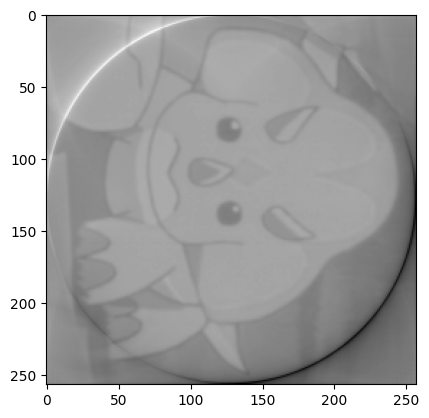

In [88]:

from scipy.fft import fft, fftshift, ifft, ifftshift

bp = np.zeros((len(sg),len(sg)))
tmp = bp.copy()

ramlak = abs(np.linspace(-1,1,len(sg)))

sinog = np.swapaxes(sinogram, 0, 1)
fft_R = fftshift(fft(sinog))
filtproj = ifftshift(fft_R * ramlak)
sg = np.real(ifft(filtproj))

sg = np.swapaxes(sg, 0, 1)


for i in range(len(sg[0,:])):
    tmp = np.repeat(sg[:,i], len(bp)).reshape((len(bp), len(bp)))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

print('reconstrucción FBP')
plt.figure()
plt.imshow(bp)


In [45]:
len(bp[:,0])

257

In [64]:
a = np.array([1, 2])
b = a[:,None]

print(np.tile(a, (2, 1)))
print(np.tile(b, (2, 1)))

[[1 2]
 [1 2]]
[[1]
 [2]
 [1]
 [2]]


In [ ]:
import scipy.sparse as sparse

#row_ptr = np.empty(N*N+1, dtype=np.int32)
#col_idx = []

#ptr = 0
#row_ptr[0] = ptr
#i = 1

A_ = set()

M = N//2

for rho in range(-M,M+1):
    for tau in range(-M, M+1):
        i = 0
        v = tau+rho*i
        while v < M*M:
            A_.add((i, v))
            i += 1
            v = tau+rho*i

        #row_ptr[i] = ptr
        #i += 1

        print(tau)
        

data = np.ones(len(A_), dtype=np.float32)

b = sinogram.flatten()
#A = A_.tocsr()
rows, cols = zip(*A_)
A = sparse.csr_matrix(np.ones(len(A_)), (rows, cols), dtype=np.float32)

test = image.flatten()

testout = (A @ test).reshape(N,N)

plt.figure()
plt.imshow(testout)

In [92]:
import scipy.sparse as sparse

#row_ptr = np.empty(N*N+1, dtype=np.int32)
#col_idx = []

#A_ = sparse.dok_array((P*L, M*N), dtype=np.float32)

A_ = set()

M = N
R = N//2
S = M//2

def imggrid(dm, dn, sz):
    # imggrid -- Returns rectilinear coordinate vectors
    #
    # SYNOPSIS
    #   [ m n ] = imggrid(dm, dn, sz)
    #
    # DESCRIPTION
    #   Given the sample spacings and the image size, this
    #   function returns the row and column coordinate vectors
    #   for the image. Both vectors are centered about zero.
    #
    # INPUT
    #   dm     Spacing between rows.
    #   dn     Spacing between columns.
    #   sz     2x1 vector of the image size: [ Nrows Ncols ].
    #
    # OUTPUT
    #   m      sz(1) x 1 row coordinate vector.
    #   n      1 x sz(2) column coordinate vector.

    M_ = sz[0]
    N_ = sz[1]
    
    if M_ % 2 == 0:
      m = dm * np.arange(np.ceil(-M_/2), np.floor(M_/2) - 1)
    else:
      m = dm * np.arange(np.ceil(-M_/2), np.floor(M_/2))
    
    if N % 2 == 0:
      n = dn * np.arange(np.ceil(-N_/2), np.floor(N_/2) - 1)
    else:
      n = dn * np.arange(np.ceil(-N_/2), np.floor(N_/2))

    return m, n


# For each angle, we define a set of rays parameterized
# by rho. We then find the pixels on the RxS grid that
# are closest to each line. The elements in A corresponding
# to those pixels are given the value of 1.

# The maximum extent of the region of support. It's for
# rho = 0 and theta = pi/4, the line that runs caddy-corner.
W = int(np.round(np.sqrt(R*R + S*S)))

rho = np.linspace(-W/2, W/2, S)

print(rho.shape)

L = len(rho)
P = len(angles)

# Define a meshgrid w/ (0,0) in the middle that
# we can use a standard coordinate system.
mimg, nimg = imggrid(1, 1, [R, S])

ptr = 0
row_ptr[0] = ptr
i = 1

# We loop over each angle and define all of the lines.
# We then just figure out which indices each line goes
# through and put a 1 there.
for i in range(P):
    phi = angles[i] * np.pi/180

    # The equaiton is rho = m * sin(phi) + n * cos(phi).
    # We either define a vector for m and solve for n
    # or vice versa. We chose which one based on angle
    # so that we never g4et close to dividing by zero.
    if(phi >= np.pi/4 and phi <= 3*np.pi/4):
        t =  np.arange(-W,W,min(1/np.sqrt(2), abs(np.tan(phi))))
        T = len(t)

        rhom = np.tile(rho[:,None], (1, T))
        tn = np.tile(t, (L, 1))
        
        mline = (rhom - tn * np.cos(phi)) / np.sin(phi)

        for j in range(L):            
            p = np.round(tn[j,:] - min(nimg)).astype(int)
            q = np.round(mline[j,:] - min(mimg)).astype(int)

            for x in q:
                for y in p:
                    #A_[i*L+j, x*S+y] = 1
                    A_.add((i*L+j, x*S+y))

    else:
        t =  np.arange(-W,W,min(1/np.sqrt(2), 1/abs(np.tan(phi))))
        T = len(t)

        rhon = np.tile(rho, (T, 1))   
        tm = np.tile(t[:,None], (1, L))

        nline = (rhon - tm * np.sin(phi)) / np.cos(phi)
    
        for j in range(L):
            p = np.round(nline[:,j] - min(nimg)).astype(int)
            q = np.round(tm[:,j] - min(mimg)).astype(int)
            
            for x in q:
                for y in p:
                    #A_[i*L+j, x*S+y] = 1
                     A_.add((i*L+j, x*S+y))

            #columnas = list(set(S*q+p))
            #columnas.sort()

            #col_idx.extend(columnas)
            #ptr += len(columnas)
            #row_ptr[i] = ptr
            #i += 1

    print(i)


#ptr = 0
#row_ptr[0] = ptr
#i = 1
#for rho in range(0,N):
#    for tau in range(0, N):
#        v = tau
#        while v < N*N:
#            col_idx.append(v)
#            v += N+rho
#            ptr += 1

#        row_ptr[i] = ptr
#        i += 1
        

#data = np.ones(len(col_idx), dtype=np.float32)

b = sinogram.flatten()
#A = A_.tocsr()
rows, cols = zip(*A_)
A = sparse.csr_matrix(np.ones(len(A_)), (rows, cols), dtype=np.float32)

test = image.flatten()

testout = (A @ test).reshape(M,N)

plt.figure()
plt.imshow(testout)

(128,)


/tmp/ipykernel_11325/3978396737.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  t =  np.arange(-W,W,min(1/np.sqrt(2), 1/abs(np.tan(phi))))


0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

reconstrucción FISTA


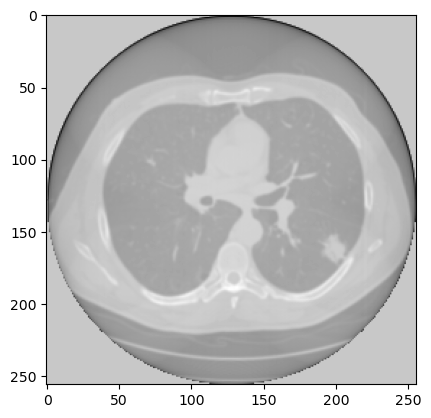

In [68]:
niter = 50
lambd = 0.1
L = 1e-4
t = 1
f = np.zeros((N,N))
fp = f.copy()
y = f.copy()

for i in range(niter):
    d = y - L * transform.iradon(transform.radon(y, theta=angles) - sinogram, theta=angles)
    #f = np.max((abs(d) - lambd * L)) * np.sign(d)
    f = d - lambd * L
    f /= np.max(np.abs(f))
    tp = (1+np.sqrt(1+4*t*t))/2
    y = f + (t - 1)/tp * (f - fp)
    fp = f.copy()
    t = tp

print('reconstrucción FISTA')
plt.figure()
plt.imshow(f)

    

In [21]:



AT = A.T
ATB =  AT @ b
#ATA = AT @ A

menosgradf = lambda x: (AT @ (A @ x)) - ATB

x = np.zeros(N*N, dtype=np.float32)

for k in range(10):
    dir = menosgradf(x)
    a = dir.T @ ATB
    b = np.linalg.norm(A @ dir)
    alfa = (a)/(b*b)
    x += alfa*dir

print(np.linalg.norm(menosgradf(x)))

gc = x.reshape(N, N)

print('reconstrucción GC')

plt.figure()
plt.imshow(gc)

TypeError: expected a sequence of integers or a single integer, got '16385.0'